In [1]:
import torch
import time
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
import lp_wealth
from sim_helpers import *

# Time Step

Each of our time steps is going to have

std. dev = $\sigma * \sqrt{\Delta_t}$

so as long as we make sure

$2 * \lvert \log{\gamma} \rvert > 4 \sigma * \sqrt{\Delta_t} \iff \Delta_t < \frac{(\log{\gamma})^2}{4\sigma^2}$

then going from a trade to the upside to a trade to the downside will be a 4-sigma event. 

## However, we still see a difference in sim results below what should be the max timestep

1 0.0007710456848144531
101 0.17135858535766602
201 0.2153468132019043
301 0.2068343162536621
401 0.20606684684753418
501 0.20615768432617188
601 0.20632624626159668
701 0.20572996139526367
801 0.20568156242370605
901 0.20423316955566406


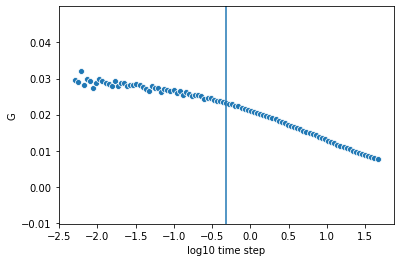

In [27]:
num_samples = 1000000

sigma = torch.tensor(0.5)
mu = sigma **2 / 2
gamma = torch.tensor(0.5)

max_time_step = get_max_time_step(gamma, sigma)


log10_max_time_step = np.log10(max_time_step)
# Choose a ton of time steps ranging from 100x below our max to 100x above
time_step_size = torch.tensor(np.logspace(log10_max_time_step -2, log10_max_time_step +2, num_samples), dtype=sigma.dtype) 

sim = lp_wealth.Sim(mu, sigma, gamma, time_step_size, num_samples, cuda=True)

num_steps = 1000

sim_loop(sim, num_steps, bb_adjustment_type="none")

bins = np.logspace(log10_max_time_step -2, log10_max_time_step +2, 100) 

s, edges, _ = scipy.stats.binned_statistic(np.array(time_step_size), sim.compute_wealth_growth_rate(), statistic = 'mean', bins=bins)
ax = sbn.scatterplot(np.log10(edges[:-1]+np.diff(edges)/2), s)
ax.set(xlabel='log10 time step', ylabel='G')
plt.axvline(log10_max_time_step)

## This problem can be fixed with a sampling adjustment

The problem is that we're sampling our market price at a fixed time step.

If the price was 10 at the last step and 11 now, it may have been 12 in between.

Happily, the CDF of its distribution is known -- see https://www.researchgate.net/publication/236984395_On_the_maximum_of_the_generalized_Brownian_bridge eq. (2.7)

Since we know trades in the same direction are path independent, and since our time step should rule out all trades in opposite directions, we can sample from this distribution to find the trades that went off between sample times.

1 0.001844644546508789
101 0.368762731552124
201 0.3613128662109375
301 0.3582456111907959
401 0.36559462547302246
501 0.37110424041748047
601 0.37334609031677246
701 0.37183046340942383
801 0.3679845333099365
901 0.3701932430267334


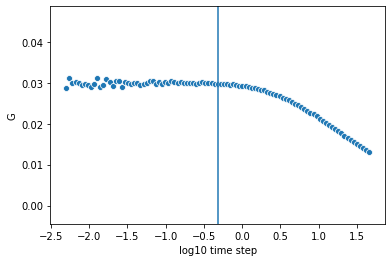

In [29]:
log10_max_time_step = np.log10(max_time_step)
# Choose a ton of time steps ranging from 100x below our max to 100x above
time_step_size = torch.tensor(np.logspace(log10_max_time_step -2, log10_max_time_step +2, num_samples), dtype=sigma.dtype) 

sim = lp_wealth.Sim(mu, sigma, gamma, time_step_size, num_samples)

sim_loop(sim, num_steps, bb_adjustment_type="sample")

bins = np.logspace(log10_max_time_step -2, log10_max_time_step +2, 100) 

s, edges, _ = scipy.stats.binned_statistic(np.array(time_step_size), sim.compute_wealth_growth_rate(), statistic = 'mean', bins=bins)
ax = sbn.scatterplot(np.log10(edges[:-1]+np.diff(edges)/2), s)
ax.set(xlabel='log10 time step', ylabel='G')
plt.axvline(log10_max_time_step)

# Wealth growth rate is eventually constant with time

We're measuring $\mathbb{E}[\displaystyle{\lim_{T\to\infty}}\frac{1}{T}\log(W(T))]$.

Now, $\log(W(T))$ is independent of $T$ (given $R_\alpha$, $R_\beta$, and $m_p$), and we initialize $W(T)$ to be $0$, so $\frac{1}{T}\log(W(T))$ is really just an average of random variables -- say, the $T$ intervals of size 1 between $0$ and $T$.

That means changes in \frac{1}{T}\log(W(T)) over time are really just be due to random noise -- there should be no drift or trend over time.

We can see that this is probably true in the graph above, since all sims with suitably small time step have the same wealth growth, despite the fact that the ones with smaller time steps have run for far less time.

However, since we're running a simulation, if the elapsed time is very small, we may not draw any samples that trade.

Now, a back and forth trade (i.e. of size $2\log{\gamma}$ in both directions) should happen ten times in our sample if

$10*2\lvert\log{\gamma}\rvert < \sigma\sqrt{T} \iff T >  400(\frac{\log{\gamma}}{\sigma})^2$

1 0.0013310909271240234
481 0.5300936698913574
961 0.5176355838775635
1441 0.5234901905059814
1921 0.5151846408843994
2401 0.5156195163726807
2881 0.5250592231750488
3361 0.5274324417114258
3841 0.5200717449188232
4321 0.5153844356536865


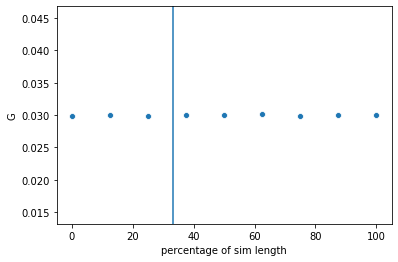

In [38]:
sigma = torch.tensor(0.5)
mu = sigma **2 / 2
gamma = torch.tensor(0.5)

num_samples=1000

time_step = max_time_step 
min_time_steps = get_min_time_steps(sigma, gamma, time_step)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)

prop = 1/3
num_steps = int(1/prop) * min_time_steps

checkpoints = sim_loop(sim, num_steps, bb_adjustment_type="sample")

means = [torch.mean(checkpoint) for checkpoint in checkpoints]
ax = sbn.scatterplot(np.arange(len(checkpoints[1:]))/(len(checkpoints)-2)*100, means[1:])
ax.set(xlabel='percentage of sim length', ylabel='G')
plt.axvline(prop * 100)


# Identities

Let wealth grown rate given $\mu, \sigma, \gamma = G(\mu,\sigma\gamma)$

### 1.) $\forall k \in \mathbb{R}^+, G(k^2\mu, k\sigma, \gamma) = k^2 G(\mu, \sigma, \gamma) $

Multiplying $\sigma$ by a constant $k$ has the same effect as speeding up the passage of time by $k^2$. If we adjust drift accordingly, that means growth rate will be $k^2$ higher.

1 0.0018503665924072266
161 0.22032475471496582
321 0.20042872428894043
481 0.2012312412261963
641 0.19587159156799316
801 0.2020103931427002
961 0.21250653266906738
1121 0.20745420455932617
1281 0.19554591178894043
1441 0.19351482391357422


[Text(0, 0.5, 'G'), Text(0.5, 0, '$\\k^2$')]

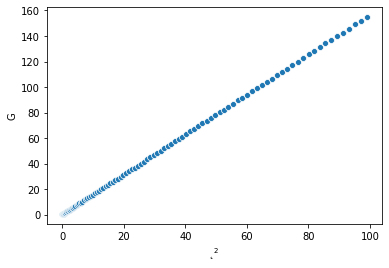

In [123]:
num_samples = 100000

k = torch.arange(0., num_samples, 1) / num_samples * 10 + 0.1
sigma = k
init_mu = 3
mu = init_mu * k**2
gamma = torch.tensor(0.6)

time_step = get_max_time_step(gamma, sigma)
num_steps = get_min_time_steps(sigma, gamma, time_step)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples, cuda=True)

sim_loop(sim, num_steps)

bins =  torch.arange(0., 100, 1) / 100 * 10 + 0.1

s, edges, _ = scipy.stats.binned_statistic(np.array(k), sim.compute_wealth_growth_rate(), statistic = 'mean', bins=bins)
ax = sbn.scatterplot((edges[:-1]+np.diff(edges)/2)**2, s)
ax.set(xlabel='$\k^2$', ylabel='G')

### 2.) $\forall k \in \mathbb{R}^+, G(\frac{k^2\sigma^2}{2}, k\sigma, \gamma^k) = k\frac{1-\gamma^k}{1+\gamma^k} G(\frac{\sigma^2}{2}, \sigma, \gamma) $


The key intuition here is that, when viewed in log space, trades occur when $m_p$ strays from $m_u$ by more than $-\log{\gamma}$, and then move $m_u$ to that boundary.

So, if we scale $\log{m_p}$ by $k$, and also scale $\log{\gamma}$ by $k$, we should see the exact same trading behavior, and $\log{m_u}$ will end up scaled by $k$ as well.

Since

$\log{W(t)} = \log{R_\alpha m_p + R_\beta} = \log{R_\beta} + \log{(1 + \frac{R_\alpha m_p}{R_\beta})} = \log{R_\beta} + \log{(1 + \frac{m_p}{m_u})}$

Then we have

$G = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}\log(W(T))] = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}\log(R_\alpha m_p + R_\beta)] =  \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}(\log{R_\beta})] $

since $\gamma \leq \frac{m_p}{m_u} \leq \frac{1}{\gamma}$ so $\log{(1 + \frac{m_p}{m_u})}$ has a finite bound. 

Now, when $\mu = \frac{\sigma^2}{2}$, there's no drift in $\log{m_p}$, so by symmetry

$\mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}(\log{R_\beta})] = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}(\log{R_\beta})]$

and we have $G = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{2T}(\log{R_\alpha} + \log{R_\beta})]$

We'll abuse notation a little bit and consider a single realization of $m_p$ and the associated parameters. Then we'll let $m_p' = k m_p$ (since we're in the 0 drift setting), $m_u'=km_u$, etc.

Consider what happens when $\gamma m_p > m_u$.

An arb will go off, after which we will have $R_\alpha(t+\delta t) = R_\alpha(t)C_l^{-\frac{\gamma}{\gamma+1}}$

so

$\log{R_\alpha(t+\delta t)} = \log{R_\alpha(t)} -\frac{\gamma}{\gamma+1}\log{C_l}$

similarly,

$\log{R_\beta(t+\delta t)} = \log{R_\beta(t)} +\frac{1}{\gamma+1}\log{C_l}$

so

$\log{R_\alpha(t+\delta t)} + \log{R_\beta(t+\delta t)} = \log{R_\alpha(t)} + \log{R_\beta(t)} + \frac{1-\gamma}{\gamma+1}\log{C_l}$

Now, $C_l = \gamma\frac{m_p}{m_u} \iff \log{C_l} = \log{\gamma} + \log{m_p} - \log{m_u}$, so we have $\log{C_l'} = k\log{C_l}$.

That means

$\log{R'_\alpha(t+\delta t)} + \log{R'_\beta(t+\delta t)} = \log{R'_\alpha(t)} + \log{R'_\beta(t)} + \frac{1-\gamma^k}{\gamma^k+1}\log{C'_l} = \log{R'_\alpha(t)} + \log{R'_\beta(t)} + k\frac{1-\gamma^k}{\gamma^k+1}\log{C_l} $

I.e. the change in $\log{R'_\alpha} + \log{R'_\beta}$ is $k\frac{1-\gamma^k}{\gamma^k+1}$ times the change in $\log{R_\alpha} + \log{R_\beta}$, so integrating we obtain

$\log{R'_\alpha} + \log{R'_\beta} = k\frac{1-\gamma^k}{1+\gamma^k}( \log{R_\alpha} + \log{R_\beta})$


So by the lemma... we're done.




1 0.0017542839050292969
161 0.21632647514343262
321 0.2043468952178955
481 0.19591617584228516
641 0.20609378814697266
801 0.1887216567993164
961 0.2012345790863037
1121 0.19196176528930664
1281 0.19603300094604492
1441 0.18796229362487793


[Text(0, 0.5, 'G'), Text(0.5, 0, '$pred$')]

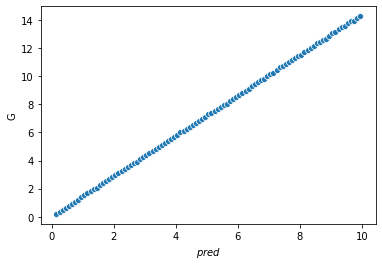

In [137]:
num_samples = 100000

k = torch.arange(0., num_samples, 1) / num_samples * 10 + 0.01
init_sigma = 2.
sigma = init_sigma * k
mu = sigma**2 / 2
init_gamma = torch.tensor(0.5)
gamma = init_gamma ** k

time_step = get_max_time_step(gamma, sigma)
num_steps = get_min_time_steps(sigma, gamma, time_step)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples, cuda=True)

sim_loop(sim, num_steps)

bins =  torch.arange(0., 100, 1) / 100 * 10 + 0.1

s, edges, _ = scipy.stats.binned_statistic((k * (1-gamma)/(1+gamma)).numpy(), sim.compute_wealth_growth_rate(), statistic = 'mean', bins=bins)
ax = sbn.scatterplot((edges[:-1]+np.diff(edges)/2), s)
ax.set(xlabel='$pred$', ylabel='G')

### 3.) $\forall k \in \mathbb{R}^+, G(\frac{\sigma^2}{2}, \sigma, \gamma^k) = \frac{1}{k}\frac{1-\gamma^k}{1+\gamma^k} G(\frac{\sigma^2}{2}, \sigma, \gamma)$

Obtained simply by combining (1) and (2).


1 0.0013785362243652344
161 0.19577407836914062
321 0.19625353813171387
481 0.20558929443359375
641 0.19508624076843262
801 0.22958636283874512
961 0.1982131004333496
1121 0.19762611389160156
1281 0.19677066802978516
1441 0.20778107643127441


[Text(0, 0.5, 'G'), Text(0.5, 0, '$pred$')]

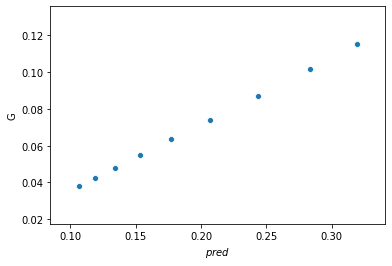

In [171]:
num_samples = 100000

k = torch.arange(0., num_samples, 1) / num_samples * 10 + 0.01
sigma = torch.tensor(1.)
mu = sigma**2 / 2
init_gamma = torch.tensor(0.5)
gamma = init_gamma ** k

time_step = get_max_time_step(gamma, sigma)
num_steps = get_min_time_steps(sigma, gamma, time_step)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples, cuda=True)

sim_loop(sim, num_steps)

pred = (1/k * (1-gamma)/(1+gamma)).numpy()

bins = np.array(np.percentile(pred, np.arange(1, 100, 10)))

y = sim.compute_wealth_growth_rate().numpy()

s, edges, _ = scipy.stats.binned_statistic(pred, y, statistic = 'mean', bins=bins)
ax = sbn.scatterplot((edges[:-1]+np.diff(edges)/2), s)
ax.set(xlabel='$pred$', ylabel='G')

# Answer to Open Problem 3.2

There is no optimal $\gamma$ in the no-drift case. LPs make more and more money as $\gamma$ is brought closer to 1, although profits approach an asymptote:


$\displaystyle{\lim_{k\to 0^+}} G(\frac{\sigma^2}{2}, \sigma, \gamma^k)= \displaystyle{\lim_{k\to 0}} \frac{1}{k}\frac{1-\gamma^k}{1+\gamma^k} G(\frac{\sigma^2}{2}, \sigma, \gamma) = -\frac{\log{\gamma}}{2} G(\frac{\sigma^2}{2}, \sigma, \gamma)$

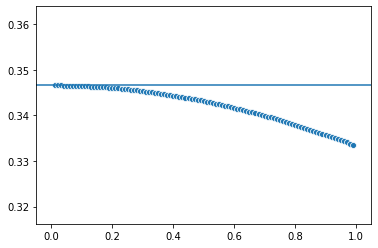

In [191]:
k = np.arange(1, 100)/100 + 0.001
gamma = .5
ans = 1 / k *(1-gamma**k)/(1+gamma**k)
sbn.scatterplot(k, ans)
plt.axhline(-np.log(gamma)/2)

### 4.) $G(\mu, 0, \gamma) =  \begin{cases}
    \frac{\mu}{\gamma+1} & \mu \geq 0\\
    \frac{\mu}{\frac{1}{\gamma}+1} & \mu < 0
  \end{cases}
$

If $\sigma = 0$, then we know $S(t) = e^{\mu t}$.

If $\mu \geq 0$, then $m_p$ is growing, so $m_u < m_p$, and in particular $\frac{R_\beta}{R_\alpha} = m_u = \gamma m_p = \gamma e^{\mu t} \iff R_\beta = R_\alpha \gamma e^{\mu t}$

WLOG, assuming we started with $R_\alpha = R_\beta = 1$, we know from path independence (since we've only ever traded in one direction) that $R_\alpha R_\beta^\gamma = 1 \iff R_\alpha = R_\beta^{-\gamma}$

Substituting this into the prior result, we end up with

$R_\beta = R_\beta^{-\gamma} \gamma e^{\mu t} \iff R_\beta = (\gamma e^{\mu t})^{\frac{1}{1 + \gamma}}$

Then $W = e^{\mu t}R_\alpha + R_\beta = \frac{\gamma +1}{\gamma}R_\beta = \frac{\gamma +1}{\gamma}(\gamma e^{\mu t})^{\frac{1}{1 + \gamma}}$

So $\log W = \log{\frac{\gamma +1}{\gamma}} + \log{(\gamma e^{\mu t})^{\frac{1}{1 + \gamma}}}
= \log{\frac{\gamma +1}{\gamma}} + \frac{1}{1 + \gamma}(\log{\gamma} + \mu t)$ 

and $G = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}\log(W(T))] = \frac{\mu}{\gamma + 1}$

By symmetry, this is $\frac{\mu}{\frac{1}{\gamma}+1}$ when $\mu < 0$

1 0.0014078617095947266
101 0.11504459381103516
201 0.10959577560424805
301 0.10847783088684082
401 0.11012434959411621
501 0.10814285278320312
601 0.11053204536437988
701 0.10871171951293945
801 0.11139798164367676
901 0.11851811408996582


[Text(0, 0.5, 'G'), Text(0.5, 0, 'pred')]

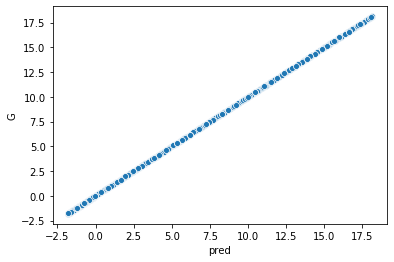

In [149]:
num_samples = 1000

sigma = torch.tensor(0.)
mu = 40 * (torch.rand(num_samples) - .5)
gamma = torch.rand(num_samples) * .9 + 0.05

time_step = torch.tensor(0.1)
num_steps = 1000

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples, cuda=True)

sim_loop(sim, num_steps)

pred = np.where(mu >0, mu / (gamma + 1), mu/(1/gamma +1))
ax = sbn.scatterplot(pred, sim.compute_wealth_growth_rate())
ax.set(xlabel='pred', ylabel='G')